In [63]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

## 1.Importing Libraries

In [64]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [65]:
pd.set_option('display.max_columns',1000)

In [66]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set on axis 0
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

df_train = pd.read_csv('../titanic/train.csv')
df_test = pd.read_csv('../titanic/test.csv')
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


## 2.Data Exploration

In [67]:
print(df_train.info())
#df_train.sample(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


**Basic Analysis on Variables:**
1. * 'PassengerId': the numerical order of passengers. H: no - There are no information given by ID.
2. * 'Pclass': Ordinal of social class. H: yes - the higher class is, 'Survived' more likely to be 1.
3. * 'Name': H:no.
4. * 'Sex': male and female. H:yes - female has 'Survived' are more likely to be 1.
5. * 'Age': H:yes - young ages are more likely to have 1.
6. * 'SibSp': H:yes - larger 'SibSp' are more likely to have 1.
7. * 'Parch': parent+childeren, H: ?.
8. * 'Ticket': H:no.
9. * 'Fare': Money paid. H: high 'Fare', high '1'
10. * 'Cabin': Cabin number. H: ?
11. * 'Embarked' place to board, C/Q/S. H: related.

In [68]:
print(df_train.info())
y_model = df_train.Survived
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null 

Missing Data:
1. Training set: 
    Age(int), Cabin('B 32'), Embarked(C/Q/S)
2. Test set:
    Age(int), Cabin('B 32'), Fare(float)

Dealing Strategy:
1. Age: find highest correlation with other features -> fill the NaN with median of the group.
2. Cabin: Difficult to deal with here. Drop the column first. ????
3. Embarked: OneHotEncoder/ But here only 2 items missing, check their features and fill them.????
4. Fare: similar to embarked.

In [69]:
df_all_corr = df_all.corr().abs().sort_values(by=['Age'], ascending=False)#.abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
Age,1.000000,0.178740,0.150917,0.028814,0.408106,0.243699,0.077221
Pclass,0.408106,0.558629,0.018322,0.038354,1.000000,0.060832,0.338481
SibSp,0.243699,0.160238,0.373587,0.055224,0.060832,1.000000,0.035322
Fare,0.178740,1.000000,0.221539,0.031428,0.558629,0.160238,0.257307
Parch,0.150917,0.221539,1.000000,0.008942,0.018322,0.373587,0.081629
Survived,0.077221,0.257307,0.081629,0.005007,0.338481,0.035322,1.000000
PassengerId,0.028814,0.031428,0.008942,1.000000,0.038354,0.055224,0.005007


In [70]:
age_by_pclass = df_all.groupby(['Pclass'])['Age'].median()
for pclass in range(1,4):
    print('Median age of Pclass {} : {}'.format(pclass, age_by_pclass[pclass]))
print('Median age of all passengers: {}'.format(df_all['Age'].median()))

Median age of Pclass 1 : 39.0
Median age of Pclass 2 : 29.0
Median age of Pclass 3 : 24.0
Median age of all passengers: 28.0


In [71]:
df_all.info()
#df_all[df_all['Age'].isnull()]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [72]:
df_age_add = pd.DataFrame(list(df_all['Age'].isnull()), columns=['Age_missing'])
df_all_tmp = pd.concat([df_all,df_age_add],axis=1)


In [73]:
df_all = df_all_tmp
df_all.head(1)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_missing
0,22.0,NaN,S,7.25,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,False


In [74]:
df_all['Age'] = df_all.groupby(['Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
### select grouped 'Age', then apply a function/method: fillna
### the function will be applied according to the group name: Pclass1, Pclass2, Pclass3 
df_all.head(5)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_missing
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,False
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,False
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,False
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,False
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,False


In [75]:
df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_missing
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,False
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,False


In [76]:
df_all.groupby(['Pclass','Sex','Parch','SibSp'])['Embarked'].value_counts()[1]['female'][0][0]

Embarked
C    30
S    20
Name: Embarked, dtype: int64

In [77]:
df_all['Embarked'] = df_all['Embarked'].fillna('C')
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
Age            1309 non-null float64
Cabin          295 non-null object
Embarked       1309 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Age_missing    1309 non-null bool
dtypes: bool(1), float64(3), int64(4), object(5)
memory usage: 124.1+ KB


In [78]:
df_all[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_missing
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,False


In [79]:
median_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp','Embarked'])['Fare'].median()[3][0][0]['S']
df_all['Fare'] = df_all['Fare'].fillna(median_fare)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
Age            1309 non-null float64
Cabin          295 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Age_missing    1309 non-null bool
dtypes: bool(1), float64(3), int64(4), object(5)
memory usage: 124.1+ KB


In [80]:
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
df_all_decks = df_all.groupby(['Deck','Pclass']).count()
df_all_decks

Age  Cabin  Embarked  Fare  Name  Parch  PassengerId  Sex  SibSp  \
Deck Pclass                                                                     
A    1        22     22        22    22    22     22           22   22     22   
B    1        65     65        65    65    65     65           65   65     65   
C    1        94     94        94    94    94     94           94   94     94   
D    1        40     40        40    40    40     40           40   40     40   
     2         6      6         6     6     6      6            6    6      6   
E    1        34     34        34    34    34     34           34   34     34   
     2         4      4         4     4     4      4            4    4      4   
     3         3      3         3     3     3      3            3    3      3   
F    2        13     13        13    13    13     13           13   13     13   
     3         8      8         8     8     8      8            8    8      8   
G    3         5      5         5     5     5      5            5    5      5   
M    1        67      0        67    67    67     67           67   67     67   
     2       254      0       254   254   254    254          254  254    254   
     3       693      0       693   693   693    693          693  693    693   
T    1         1      1         1     1     1      1            1    1      1   

             Survived  Ticket  Age_missing  
Deck Pclass                                 
A    1             15      22           22  
B    1             47      65           65  
C    1             59      94           94  
D    1             29      40           40  
     2              4       6            6  
E    1             25      34           34  
     2              4       4            4  
     3              3       3            3  
F    2              8      13           13  
     3              5       8            8  
G    3              4       5            5  
M    1             40      67           67  
     2            168     254          254  
     3            479     693          693  
T    1              1       1            1

#### Create Deck feature

In [81]:
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
df_all_decks = df_all.groupby(['Deck','Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()
def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages    
all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)

In [82]:
# Passenger in the T deck is changed to A
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'


In [83]:
df_all_decks_survived = df_all.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)

In [84]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()
# Dropping the Cabin feature
df_all.drop(['Cabin'], inplace=True, axis=1)

In [85]:
df_all.groupby(['Deck','Pclass']).count()

Age  Embarked  Fare  Name  Parch  PassengerId  Sex  SibSp  \
Deck Pclass                                                              
ABC  1       182       182   182   182    182          182  182    182   
DE   1        74        74    74    74     74           74   74     74   
     2        10        10    10    10     10           10   10     10   
     3         3         3     3     3      3            3    3      3   
FG   2        13        13    13    13     13           13   13     13   
     3        13        13    13    13     13           13   13     13   
M    1        67        67    67    67     67           67   67     67   
     2       254       254   254   254    254          254  254    254   
     3       693       693   693   693    693          693  693    693   

             Survived  Ticket  Age_missing  
Deck Pclass                                 
ABC  1            122     182          182  
DE   1             54      74           74  
     2              8      10           10  
     3              3       3            3  
FG   2              8      13           13  
     3              9      13           13  
M    1             40      67           67  
     2            168     254          254  
     3            479     693          693

In [86]:
df_all.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_missing,Deck
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,False,M
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,False,ABC
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,False,M
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,False,ABC
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,False,M


#### Create Family_Size = SibSp + Parch + 1

In [87]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] +1

family_map = {1: 'Alone', 2:'Small', 3:'Small', 4:'Small', 5:'Medium',6:'Medium', 7:'Large', 8:'Large', 9:'Large',10:'Large',11:'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)


In [88]:
#df_all['Family_Size_Grouped']=='Alone'

In [89]:
#df_all['Is_Alone'] = df_all[df_all['Family_Size_Grouped']==]

In [90]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

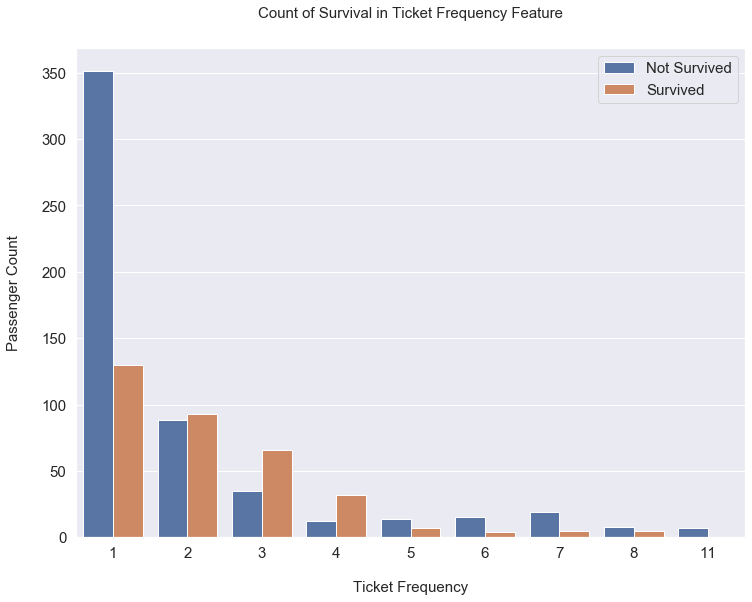

In [91]:
fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=df_all)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)

plt.show()

#### Fare qcut

In [92]:
df_all['Fare'] = pd.qcut(df_all['Fare'],13)

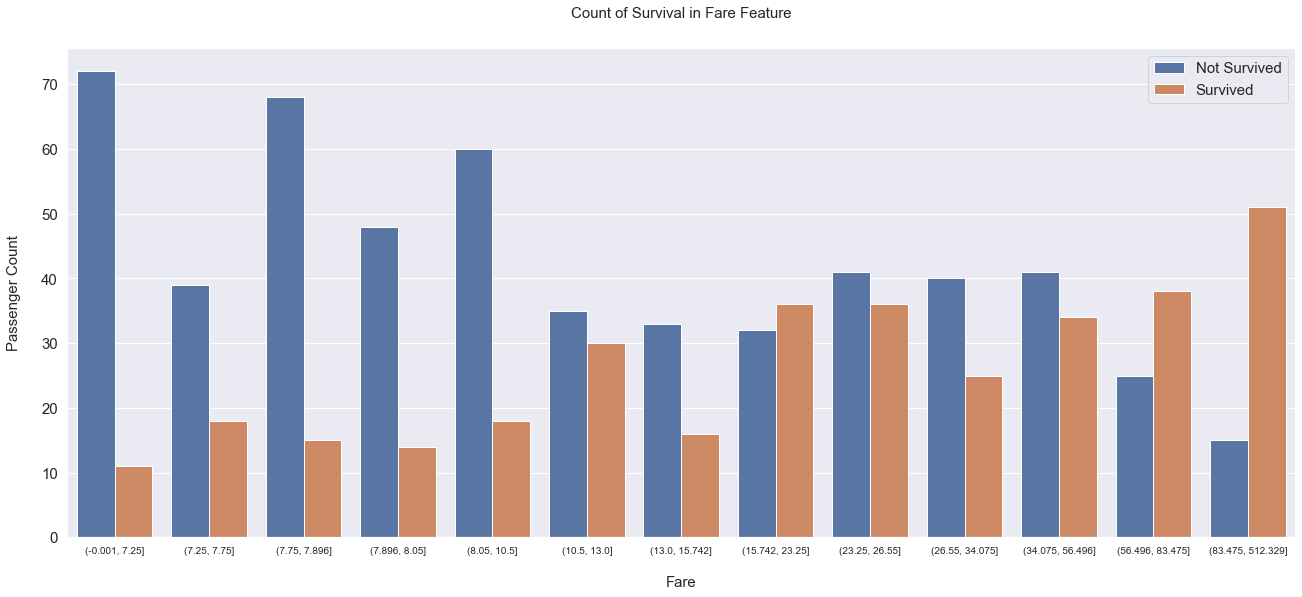

In [93]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=df_all)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

#### Age qcut

In [94]:
df_all_test = df_all.copy()
bins = [0,4,9,12,15,18,22,26,30,34,38,45,52,60,70,100]
df_all_test['Age'] = pd.cut(df_all_test['Age'],bins=bins,right=True)
#df_all['Age'] = pd.qcut(df_all['Age'],14,duplicates = 'drop')

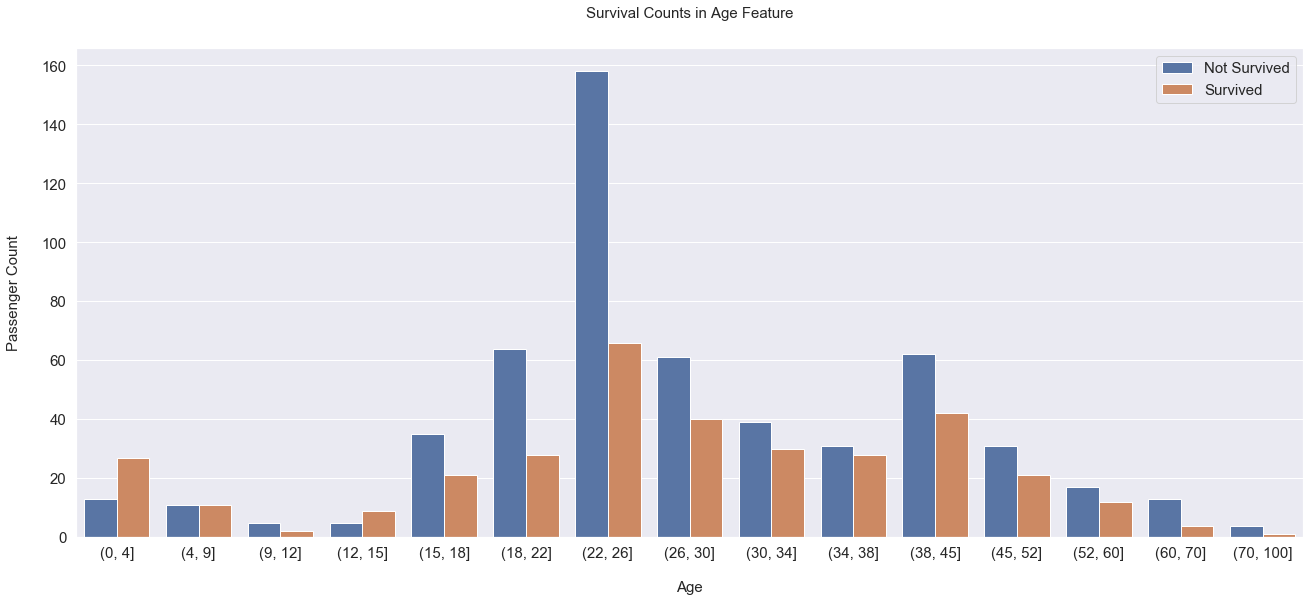

In [95]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=df_all_test)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

In [96]:
df_all = df_all_test.copy()

In [97]:
df_train, df_test = divide_df(df_all)
df_train.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_missing,Deck,Family_Size,Family_Size_Grouped,Ticket_Frequency
0,"(18, 22]",S,"(-0.001, 7.25]","Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,False,M,2,Small,1
1,"(34, 38]",C,"(56.496, 83.475]","Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,False,ABC,2,Small,2
2,"(22, 26]",S,"(7.896, 8.05]","Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,False,M,1,Alone,1
3,"(34, 38]",S,"(34.075, 56.496]","Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,False,ABC,2,Small,2
4,"(34, 38]",S,"(7.896, 8.05]","Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,False,M,1,Alone,1


In [98]:
df_test.columns

Index(['Age', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass',
       'Sex', 'SibSp', 'Ticket', 'Age_missing', 'Deck', 'Family_Size',
       'Family_Size_Grouped', 'Ticket_Frequency'],
      dtype='object')

In [99]:
df_train.columns

Index(['Age', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass',
       'Sex', 'SibSp', 'Survived', 'Ticket', 'Age_missing', 'Deck',
       'Family_Size', 'Family_Size_Grouped', 'Ticket_Frequency'],
      dtype='object')

#### Name -> family, title

In [100]:
def name_sep(data):
    families=[]
    titles = []
    new_name = []
    #for each row in dataset:
    for i in range(len(data)):
        name = data.iloc[i]
        # extract name inside brakets into name_bracket:
        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(",")[0]
        title = name_no_bracket.split(",")[1].strip().split(" ")[0]
        
        #remove punctuations accept brackets:
        for c in string.punctuation:
            name = name.replace(c,"").strip()
            family = family.replace(c,"").strip()
            title = title.replace(c,"").strip()
            
        families.append(family)
        titles.append(title)
        new_name.append(name)
            
    return families, titles, new_name   

In [101]:
df_train['family'], df_train['title'], df_train['Name']  = name_sep(df_train.Name)
df_test['family'], df_test['title'], df_test['Name'] = name_sep(df_test.Name)


In [102]:
# for t in df_train['title'].unique():
#     if len(df_train[df_train['title']==t]) <= 15:
#         df_train.loc[df_train.title ==t, 'title'] = 'OTHER'
        
# for t in df_test['title'].unique():
#     if t not in df_train['title'].unique():
#         df_test.loc[df_test.title ==t, 'title'] = 'OTHER'
        
# print(df_train['title'].unique())
# print(df_test['title'].unique())

In [103]:
overlap = [x for x in df_train.family.unique() if x in df_test.family.unique()]

In [104]:
rate_family = df_train.groupby('family')['Survived','Family_Size'].median()
rate_family.head()

,Survived,Family_Size
family,,
Abbing,0.0,1.0
Abbott,0.5,3.0
Abelson,0.5,2.0
Adahl,0.0,1.0
Adams,0.0,1.0


In [105]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
Age                    891 non-null category
Embarked               891 non-null object
Fare                   891 non-null category
Name                   891 non-null object
Parch                  891 non-null int64
PassengerId            891 non-null int64
Pclass                 891 non-null int64
Sex                    891 non-null object
SibSp                  891 non-null int64
Survived               891 non-null float64
Ticket                 891 non-null object
Age_missing            891 non-null bool
Deck                   891 non-null object
Family_Size            891 non-null int64
Family_Size_Grouped    891 non-null object
Ticket_Frequency       891 non-null int64
family                 891 non-null object
title                  891 non-null object
dtypes: bool(1), category(2), float64(1), int64(6), object(8)
memory usage: 107.5+ KB


In [106]:
overlap_family = {}
for i in range(len(rate_family)):
    if rate_family.index[i] in overlap and rate_family.iloc[i,1] >1:
        overlap_family[rate_family.index[i]] = rate_family.iloc[i,0]

In [107]:
mean_survival_rate = np.mean(df_train.Survived)
family_survival_rate = []
family_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train.family[i] in overlap_family:
        family_survival_rate.append(overlap_family[df_train.family[i]])
        family_survival_rate_NA.append(1)
    else:
        family_survival_rate.append(mean_survival_rate)
        family_survival_rate_NA.append(0)

df_train['family_survival_rate'] = family_survival_rate
df_train['family_survival_rate_NA'] = family_survival_rate_NA

In [108]:
family_survival_rate = []
family_survival_rate_NA = []

for i in range(len(df_test)):
    if df_test.family.iloc[i] in overlap_family:
        family_survival_rate.append(overlap_family[df_test.family.iloc[i]])
        family_survival_rate_NA.append(1)
    else:
        family_survival_rate.append(mean_survival_rate)
        family_survival_rate_NA.append(0)

df_test['family_survival_rate'] = family_survival_rate
df_test['family_survival_rate_NA'] = family_survival_rate_NA

In [109]:
df_train = df_train.drop(['Name', 'family'], axis=1)
df_test = df_test.drop(['Name', 'family'], axis=1)

df_test.head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Ticket,Age_missing,Deck,Family_Size,Family_Size_Grouped,Ticket_Frequency,title,family_survival_rate,family_survival_rate_NA
891,"(34, 38]",Q,"(7.75, 7.896]",0,892,3,male,0,330911,False,M,1,Alone,1,Mr,0.383838,0
892,"(45, 52]",S,"(-0.001, 7.25]",0,893,3,female,1,363272,False,M,2,Small,1,Mrs,0.383838,0
893,"(60, 70]",Q,"(8.05, 10.5]",0,894,2,male,0,240276,False,M,1,Alone,1,Mr,0.383838,0
894,"(26, 30]",S,"(8.05, 10.5]",0,895,3,male,0,315154,False,M,1,Alone,1,Mr,0.383838,0
895,"(18, 22]",S,"(10.5, 13.0]",1,896,3,female,1,3101298,False,M,3,Small,2,Mrs,1.000000,1


In [110]:
df_train = df_train.drop('Survived',axis=1)

check the data

In [111]:
# df_train, df_test = divide_df(df_all)
# dfs = [df_train, df_test]

# df_all.head(3)


In [112]:
df_train.shape

(891, 17)

In [113]:
df_test.shape

(418, 17)

## Correlations

In [49]:
# corr = df_train.corr()

# ax = sns.heatmap(
#     corr, 
#     vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(0, 200, n=200),
#     square=True
# )
# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     rotation=45,
#     horizontalalignment='right'
# );
# ax.set_yticklabels(
#     ax.get_yticklabels(),
#     rotation=45,
#     verticalalignment='center'
# );

### Categorical Features

In [50]:
# df_all.head()

In [51]:
# df_train = df_all.loc[:890]
# df_test = df_all.loc[891:]

#here dfs is a 2cols list, each col is a df.

In [114]:
df_train.head(2)

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Ticket,Age_missing,Deck,Family_Size,Family_Size_Grouped,Ticket_Frequency,title,family_survival_rate,family_survival_rate_NA
0,"(18, 22]",S,"(-0.001, 7.25]",0,1,3,male,1,A/5 21171,False,M,2,Small,1,Mr,0.383838,0
1,"(34, 38]",C,"(56.496, 83.475]",0,2,1,female,1,PC 17599,False,ABC,2,Small,2,Mrs,1.000000,1


In [115]:
df_test.head(2)

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Ticket,Age_missing,Deck,Family_Size,Family_Size_Grouped,Ticket_Frequency,title,family_survival_rate,family_survival_rate_NA
891,"(34, 38]",Q,"(7.75, 7.896]",0,892,3,male,0,330911,False,M,1,Alone,1,Mr,0.383838,0
892,"(45, 52]",S,"(-0.001, 7.25]",0,893,3,female,1,363272,False,M,2,Small,1,Mrs,0.383838,0


In [122]:
df_all = concat_df(df_train, df_test)

### label encode

In [124]:
#dfs = [df_train, df_test]
non_numeric_features = ['Embarked', 'Sex', 'Deck','title', 'Age', 'Fare','Family_Size_Grouped']

for feature in non_numeric_features:
    df_all[feature] = LabelEncoder().fit_transform(df_all[feature])
    
# for df in dfs:
#     for feature in non_numeric_features:        
#         df[feature] = LabelEncoder().fit_transform(df[feature])

In [58]:
# age_map = {0:0,3:0,
#            1:1,2:1,9:1,12:1,
#            4:2,5:2,6:2,7:2,8:2,10:2,11:2,13:2,14:2
#           }
# df_train['Age'] = df_train.Age.map(age_map)
# df_test['Age'] = df_test.Age.map(age_map)
# df_train.Age.value_counts(dropna=False)

In [59]:
# fare_map = {5:0,7:0,8:0,10:0,
#             0:1,1:1,2:1,3:1,4:1,6:1,9:1,
#             11:2,12:2
#            }
# df_train['Fare'] = df_train.Fare.map(fare_map)
# df_test['Fare'] = df_test.Fare.map(fare_map)
# df_train.Fare.value_counts(dropna=False)

### onehot encode

In [134]:
cat_features = [ 'Embarked','Sex','Pclass','Fare', 'Age','Deck','title','Family_Size_Grouped']
encoded_features = []

for feature in cat_features:
    try:
        encoded_feat = OneHotEncoder().fit_transform(df_all[feature].values.reshape(-1, 1)).toarray()
    except:
        print(feature)
    n = df_all[feature].nunique(dropna=False)
    #print(n)
    cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
    encoded_df = pd.DataFrame(encoded_feat, columns=cols)
    encoded_df.index = df_all.index
    df_all = df_all.join(encoded_df)
#         n = df[feature].nunique()
#         cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
#         encoded_df = pd.DataFrame(encoded_feat, columns=cols)
#         encoded_df.index = df.index
#         encoded_features.append(encoded_df)

# df_train = pd.concat([df_train, *encoded_features[:8]], axis=1)
# df_test = pd.concat([df_test, *encoded_features[8:]], axis=1)

In [135]:
df_all.shape

(1309, 79)

In [136]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 79 columns):
Age                        1309 non-null int32
Age_missing                1309 non-null bool
Deck                       1309 non-null int32
Embarked                   1309 non-null int32
Family_Size                1309 non-null int64
Family_Size_Grouped        1309 non-null int32
Fare                       1309 non-null int32
Parch                      1309 non-null int64
PassengerId                1309 non-null int64
Pclass                     1309 non-null int64
Sex                        1309 non-null int32
SibSp                      1309 non-null int64
Ticket                     1309 non-null object
Ticket_Frequency           1309 non-null int64
family_survival_rate       1309 non-null float64
family_survival_rate_NA    1309 non-null int64
title                      1309 non-null int32
Embarked_1                 1309 non-null float64
Embarked_2                 1309 non-null fl

In [137]:
#df_all = concat_df(df_train, df_test)
#df_all.head()
drop_cols = ['Embarked','PassengerId', 'Pclass', 'Sex','SibSp','Parch','Deck','Ticket','Family_Size_Grouped',
             'Family_Size','title','Age','Fare'
            ]

df_all.drop(columns=drop_cols, inplace=True)

df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 66 columns):
Age_missing                1309 non-null bool
Ticket_Frequency           1309 non-null int64
family_survival_rate       1309 non-null float64
family_survival_rate_NA    1309 non-null int64
Embarked_1                 1309 non-null float64
Embarked_2                 1309 non-null float64
Embarked_3                 1309 non-null float64
Sex_1                      1309 non-null float64
Sex_2                      1309 non-null float64
Pclass_1                   1309 non-null float64
Pclass_2                   1309 non-null float64
Pclass_3                   1309 non-null float64
Fare_1                     1309 non-null float64
Fare_2                     1309 non-null float64
Fare_3                     1309 non-null float64
Fare_4                     1309 non-null float64
Fare_5                     1309 non-null float64
Fare_6                     1309 non-null float64
Fare_7            

In [138]:
df_all.shape

(1309, 66)

### PCA

In [233]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 16).fit(df_all)
X_pca = pca.transform(df_all)

In [234]:
pca.explained_variance_ratio_

array([0.40627371, 0.10121404, 0.07341462, 0.05387497, 0.04657151,
       0.03023835, 0.02709924, 0.01957804, 0.01568958, 0.01373155,
       0.01339552, 0.01232798, 0.01173894, 0.01110983, 0.01071694,
       0.00998321])

In [235]:
pca.components_[0].shape

(66,)

In [240]:
X_pca.shape[1]

16

In [241]:
df_all_pca = pd.DataFrame(data=X_pca, 
                          index=range(0,1309),
                          columns=["PCA_{}".format(i) for i in range(1,X_pca.shape[1]+1)]
                         )

In [242]:
df_all_pca.shape

(1309, 16)

In [243]:
df_all_pca.head(3)

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16
0,-1.114509,0.361961,0.070283,-0.601781,0.814520,-0.644751,0.498706,-0.049357,-0.155054,-0.030049,-0.492793,-0.46526,-0.520962,-0.062254,0.588582,0.482794
1,0.435845,-2.198501,0.801290,0.566161,0.749223,-0.163055,0.128665,0.329571,-0.333960,0.171885,-0.125710,0.45852,0.311946,0.238050,0.163672,-0.321715
2,-1.068426,-0.478929,-1.388956,0.162466,-0.608982,-0.406583,-0.280704,-0.199177,-0.391617,-0.465086,0.053521,0.09241,-0.073491,-0.380520,-0.165018,-0.195140


Prepare for model and final

In [61]:
#columns_to_scale = ['']

In [165]:
X_model = df_all_pca.loc[:890]
X_final = df_all_pca.loc[891:]

In [166]:
X_model.shape

(891, 10)

In [167]:
y_model.shape

(891,)

In [168]:
X_final.shape

(418, 10)

Prepare for training set split: X_model ->  X_train, X_test

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_dev, y_train, y_dev = train_test_split(X_model, y_model, train_size = 0.8, random_state = 123)

Scaling

In [67]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler().fit(X_train)
# X_train_scaled = pd.DataFrame(sc.transform(X_train),
#                               index = X_train.index.values, 
#                               columns = X_train.columns.values
#                              )
# X_test_scaled  = pd.DataFrame(sc.transform(X_test),
#                               index = X_test.index.values,
#                               columns = X_test.columns.values
#                               )
# X_model_scaled = pd.DataFrame(sc.transform(X_model),
#                               index = X_model.index.values,
#                               columns = X_model.columns.values
#                               )
# X_final_scaled = pd.DataFrame(sc.transform(X_final),
#                        index = X_final.index.values,
#                        columns = X_final.columns.values
#                        )

In [68]:
X_model.shape
#X_model.info()

(891, 31)

### Feature Importance Selection:  Method 1

##### Add 1 column: binary 01

In [69]:
import random


X_model_test = X_model.copy()
X_model_test['Test_binary01'] = [random.randint(0,1) for i in range(X_model.shape[0])]
# X_model_test['Test_randint_Age'] = [random.randint(0,max(X_model['Age'])) for i in range(X_model.shape[0])]
# X_model_test['Test_randint_Fare'] = [random.randint(0,max(X_model['Fare'])) for i in range(X_model.shape[0])]

#X_model_test.head()

RF_test = RandomForestClassifier(bootstrap = True, 
                                 max_features='sqrt',
                                 n_estimators = 700,
                                 min_samples_leaf =  2,
                                 max_depth = 7
                                )

from xgboost import XGBClassifier
RF_test2 = XGBClassifier(learning_rate=0.1,n_estimators=700)

#f, axes = plt.subplots(1, 2,figsize=(15,15))


models = [RF_test,RF_test2]

feature_to_delete = []

for i in range(len(models)):
    models[i].fit(X_model_test,y_model)
    feature_importances = models[i].feature_importances_
    feature_names = list(X_model_test.columns)
    feature_importances_dict = dict(zip(feature_names,feature_importances))
    feature_importances_dictlist = sorted(feature_importances_dict.items(),
                                          key=lambda item:item[1], 
                                          reverse=True
                                         )
#     plt_feature,plt_importance=zip(*feature_importances_dictlist)
#     pltx, plty = zip(*feature_importances_dictlist)
#     sns.barplot(list(plt_importance),list(plt_feature),ax=axes[i])
    
    feature_to_delete.append([f for f in feature_importances_dict if feature_importances_dict[f] < feature_importances_dict['Test_binary01']])



In [70]:
feature_delete = set(feature_to_delete[0])
for i in range(len(feature_to_delete)):
    feature_delete = set(feature_to_delete[i]) & feature_delete
print(feature_delete)
print(feature_to_delete[0])
print(feature_to_delete[1])

{'Family_Size_Grouped_2'}
['Age_2', 'Age_missing', 'Deck_3', 'Embarked_1', 'Embarked_2', 'Family_Size_Grouped_2', 'title_5']
['Age_1', 'Family_Size_Grouped_2', 'Fare_1', 'Fare_3', 'Sex_2', 'title_2', 'title_4']


### Feature Importance Selection:  Method 2
#### sklearn RFE (recursively delete feature 1 by 1)

In [71]:
from sklearn.feature_selection import RFE
estimator = RF_test
selector = RFE(estimator, 8, step=1)
selector = selector.fit(X_model, y_model)
selector.support_ 
#selector.ranking_


array([False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False,  True, False,
       False, False,  True,  True,  True,  True,  True, False, False,
       False,  True, False, False])

In [72]:
X_model = X_model.drop(list(X_model.columns[~selector.support_ ]),axis=1)
X_model.head(1)
X_final = X_final.drop(list(X_final.columns[~selector.support_ ]),axis=1)
X_final.shape

(418, 8)

In [74]:
#X_model.head(1)

### Feature Importance Selection:  Method 3
#### Boruta Shadow Feature Algorithm

In [110]:
# at maximum reduces half features each iteration
import random

X_model_test = X_model.copy()

RF_test = RandomForestClassifier(bootstrap = True, 
                                 max_features='sqrt',
                                 n_estimators = 700,
                                # min_samples_leaf =  2,
                                 max_depth = 6,
                                 random_state=123
                                )

total_droplist = []
early_break = 0
for j in range(10):
    n = len(list(X_model_test.columns))
    if n < 15: break
    droplist = []
    for i in range(n):
        #print(i)
        X_model_test2 = X_model_test.copy()

        feature = X_model_test.columns[i]

        X_model_test2['shadow'] = X_model_test2[feature].copy()
       # print(feature)
        X_model_test2['shadow'] = random.sample(list(X_model_test2['shadow']), len(list(X_model_test2['shadow']))) 
        #random.shuffle(X_model_test2['shadow'])
        RF_test.fit(X_model_test2,y_model)

        if RF_test.feature_importances_[i] < RF_test.feature_importances_[n]:
            droplist.append(feature)
            total_droplist.append(feature)
    print(droplist) 
    X_model_test = X_model_test.drop(droplist,axis=1)
    
    if not droplist: 
        early_break += 1
        
    if early_break >= 3 :
        break
        
print(total_droplist)


['Age_missing', 'Deck_3', 'Embarked_2', 'Family_Size_Grouped_1']
['Age_3', 'Fare_1']
[]
[]
[]
['Age_missing', 'Deck_3', 'Embarked_2', 'Family_Size_Grouped_1', 'Age_3', 'Fare_1']


In [140]:
# X_model = X_model.drop(total_droplist,axis=1)
# X_final = X_final.drop(total_droplist,axis=1)

In [112]:
X_model.head()

,Age_1,Age_2,Deck_1,Deck_2,Deck_4,Embarked_1,Embarked_3,Family_Size_Grouped_2,Family_Size_Grouped_3,Family_Size_Grouped_4,Fare_2,Fare_3,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Ticket_Frequency,family_survival_rate,family_survival_rate_NA,title_1,title_2,title_3,title_4,title_5
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1,0.383838,0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,2,1.000000,1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1,0.383838,0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2,0.383838,0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1,0.383838,0,0.0,0.0,1.0,0.0,0.0


# Train and Predict

### now we have
'X_train_scaled', 'y_train':  to  train the model<br>
'X_test_scaled', 'y_test: to get scores of models       <br>        # Will train error high and test error low happen? 

### Try different model (now without Hyperparameter tuning (CV), later add it)

In [244]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit,LeaveOneOut,KFold
cv =  StratifiedShuffleSplit(n_splits=10, test_size=.20,random_state=143) # need to learn

In [245]:
All_models = {} # {model1: model1_score, model2:model2_score}

In [246]:
import time

#### 1. Random Forest

In [247]:

cv =  StratifiedShuffleSplit(n_splits=5,random_state=188) # need to learn

##### Nested CV

In [189]:
# to know how the 'type of model' behave 
def nestedCV(model,param,X,y):
    nestedCV_score = []
    cv_out =  KFold(n_splits=5, shuffle=True, random_state=143)
    cv_in = StratifiedShuffleSplit(n_splits=5,random_state=123)
    for train_idx,test_idx in cv_out.split(X,y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        best_m = GridSearchCV(model,param,cv=cv_in)
        best_m.fit(X_train,y_train)
        s = best_m.best_estimator_.score(X_test,y_test)
        nestedCV_score.append(s)
    #return np.mean(nestedCV_score)
    return nestedCV_score

In [190]:
print(nestedCV(RandomForestClassifier(),parameters,X_model,y_model))

[0.7932960893854749, 0.7303370786516854, 0.8370786516853933, 0.8146067415730337, 0.8314606741573034]


In [ ]:
#t0 = time.clock()
X_train,y_train = X_model.copy(),y_model.copy()
parameters = {'n_estimators':[15,30,50,100],
              'min_samples_leaf': [1,2,3,4], #list(range(1,4)),
              'max_depth' : [1,2,3]#list(range(3,7))
             }
RF = GridSearchCV(estimator=RandomForestClassifier(bootstrap = True, max_features='sqrt'),
                           param_grid=parameters,
                           cv=10,
                           n_jobs = -1
                          )

RF.fit(X_train,y_train) 
print("The best CV score is:\n{:0.4f}".format(RF.best_score_))

# #t1 = time.clock()
# print(t1-t0)

In [192]:
#RF.best_estimator_.score(X_dev,y_dev)

In [202]:
RF.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=1, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=700,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [456]:
All_models.update({RF.best_estimator_ : RF.best_score_})

In [457]:

#RF.best_estimator_.score(X_dev,y_dev)

In [458]:
# from sklearn.feature_selection import RFECV


# selector = RFECV(RF.best_estimator_, step=1, cv=5)
# selector = selector.fit(X_train,y_train)
# selector.support_ 

In [459]:
# X_model5 = X_model4.loc[:,selector.support_]
# X_model5.head()

In [460]:
# np.mean(cross_val_score(RF_test, X_model4, y_model, cv=5))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=700,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### 2. KNN

In [461]:
from sklearn.neighbors import KNeighborsClassifier
n_neighbors = [1]#range(2)
weights=['uniform','distance']
parameters = {'n_neighbors':n_neighbors, 
              'weights':weights
             }
KNN = GridSearchCV(KNeighborsClassifier(), 
                           parameters,
                           cv=cv,
                           verbose = False, 
                           n_jobs=-1
                          )
#KNN.fit(X_train,y_train) 
KNN.fit(X_model,y_model)
print("The best CV score is:\n{:0.4f}".format(KNN.best_score_))

The best CV score is:
0.7872


In [462]:
KNN.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [463]:
All_models.update({KNN.best_estimator_: KNN.best_score_})

#### 3. Bagging Classifier

In [464]:
from sklearn.ensemble import BaggingClassifier
n_estimators = [20]#[100,200,400,500,700,1000]
parameters = {'n_estimators':n_estimators,
              }
BG = GridSearchCV(BaggingClassifier(max_features=2 ),
                  param_grid=parameters,
                  cv=cv,
                  n_jobs = -1
                 )
#BG.fit(X_train,y_train) 
BG.fit(X_model,y_model)
print("The best CV score is:\n{:0.4f}".format(BG.best_score_))



The best CV score is:
0.8061


In [465]:
BG.best_estimator_

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=2, max_samples=1.0, n_estimators=20, n_jobs=None,
                  oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

In [466]:
All_models.update({BG.best_estimator_ : BG.best_score_})

#### 4. SVM

In [467]:
from sklearn.svm import SVC
Cs = [0.02] ## penalty parameter C for the error term. 
gammas = [0.001, 0.01, 0.1, 0.2, 0.4, 1]
kernels = ['rbf','poly']
param_grid = {'C': Cs, 'gamma' : gammas}
SVM = GridSearchCV(SVC(probability=True), 
                   param_grid, 
                   cv=cv
                  )
#SVM.fit(X_train,y_train)
SVM.fit(X_model,y_model)
print("The best CV score is:\n{:0.4f}".format(SVM.best_score_))

The best CV score is:
0.7447


In [468]:
SVM.best_estimator_

SVC(C=0.02, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.2, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [469]:
All_models.update({SVM.best_estimator_ : SVM.best_score_})

#### 5. AdaBoost

In [470]:
from sklearn.ensemble import AdaBoostClassifier
n_estimators = [50,100]
learning_r = [.016]
parameters = {'n_estimators':n_estimators,
              'learning_rate':learning_r
              }
ADB = GridSearchCV(AdaBoostClassifier(),
                   param_grid=parameters,
                   cv=cv,
                   n_jobs = -1
                  )
#ADB.fit(X_train,y_train)
ADB.fit(X_model,y_model)
print("The best CV score is:\n{:0.4f}".format(ADB.best_score_))

The best CV score is:
0.7849


In [471]:
ADB.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                   learning_rate=0.016, n_estimators=100, random_state=None)

In [472]:
All_models.update({ADB.best_estimator_ : ADB.best_score_})

#### 6.Extra Trees 

In [473]:
from sklearn.ensemble import ExtraTreesClassifier
EXT = ExtraTreesClassifier(max_depth=2)

In [474]:
from sklearn.model_selection import cross_val_score

EXT_score = np.mean(cross_val_score(EXT, X_model,y_model, cv=cv))
print("The CV score is:\n{:0.4f}".format(EXT_score))
#EXT.fit(X_train,y_train)        
EXT.fit(X_model,y_model)

The CV score is:
0.7765


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=2, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [475]:
#All_models.pop(EXT)

In [476]:
All_models.update({EXT : EXT_score+0.0001})

#### 7. Gaussian Naive Bayesian

In [477]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

GNB = GaussianNB()
GNB_score = np.mean(cross_val_score(GNB, X_model,y_model, cv=cv))
print("The CV score is:\n{:0.4f}".format(GNB_score))
#GNB.fit(X_train,y_train)     
GNB.fit(X_model,y_model)
# gaussian.fit(X, y)
# y_pred = gaussian.predict(X_test)
# gaussian_accy = round(accuracy_score(y_pred, y_test), 3)
#print(gaussian_accy)

The CV score is:
0.7972


GaussianNB(priors=None, var_smoothing=1e-09)

In [478]:
All_models.update({GNB: GNB_score})

#### 8. Decision Tree

In [479]:
from sklearn.tree import DecisionTreeClassifier
max_depth = range(1,3)
#max_feature = [21,22,23,24,25,'auto']
criterion=["entropy", "gini"]

param = {'max_depth':max_depth, 
        # 'max_features':max_feature, 
         'criterion': criterion}
DT = GridSearchCV(DecisionTreeClassifier(), 
                                param_grid = param, 
                                 verbose=False, 
                                 cv=cv,#StratifiedKFold(n_splits=20, random_state=15, shuffle=True),
                                n_jobs = -1)
#DT.fit(X_train,y_train) 
DT.fit(X_model,y_model)
print("The best CV score is:\n{:0.4f}".format(DT.best_score_))

The best CV score is:
0.8078


In [480]:
DT.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [481]:
All_models.update({DT.best_estimator_ : DT.best_score_})

#### 9. Gradient Boost Classifier

In [482]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

learning_rate = [0.003]
n_estimators = [100]
loss = ['deviance','exponential']
param = {'learning_rate': learning_rate,
         'n_estimators' : n_estimators,
         'loss': loss
        }
GB = GridSearchCV(GradientBoostingClassifier(), 
                                param_grid = param, 
                                 verbose=False, 
                                 cv=cv,#StratifiedKFold(n_splits=20, random_state=15, shuffle=True),
                                n_jobs = -1
                 )
#GB.fit(X_train,y_train) 
GB.fit(X_model,y_model)
print("The best CV score is:\n{:0.4f}".format(GB.best_score_))

The best CV score is:
0.7793


In [483]:
GB.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.003, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [484]:
All_models.update({GB.best_estimator_: GB.best_score_})

#### 10. XGB

In [485]:
from xgboost import XGBClassifier

n_estimators = [10]
learning_rate = [0.001]

param = {'learning_rate': learning_rate,
         'n_estimators' : n_estimators,
         'max_depth' : [2]
        }
XGB = GridSearchCV(XGBClassifier(), 
                    param_grid = param, 
                     cv=cv,#StratifiedKFold(n_splits=20, random_state=15, shuffle=True),
                    n_jobs = -1
                 )
#XGB.fit(X_train,y_train)
XGB.fit(X_model,y_model)

# XGB = XGBClassifier(n_estimators = 800,
#                       objective= 'binary:logistic',
#                       learning_rate=0.01,
#                       scale_pos_weight = 1.6,
#                       verbose_eval=10)
# XGB_score = np.mean(cross_val_score(XGB, X_model, y_model, cv=100))
print("The CV score is:\n{:0.4f}".format(XGB.best_score_))

The CV score is:
0.8078


In [486]:
XGB.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.001, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [487]:
All_models.update({XGB.best_estimator_: XGB.best_score_})

In [488]:
# selector = RFECV(XGB.best_estimator_, step=1, cv=5)
# selector = selector.fit(X_model4, y_model)
# selector.support_ 

In [489]:
# X_model4.head()

In [490]:
# X_model5 = X_model4.loc[:,selector.support_]
# X_model5.head()


In [491]:
# np.mean(cross_val_score(XGB.best_estimator_, X_model4, y_model, cv=20))

#### 11.Gaussian Process Classifier 

In [492]:
from sklearn.gaussian_process import GaussianProcessClassifier
GPC = GaussianProcessClassifier(max_iter_predict = 1)
GPC_score = np.mean(cross_val_score(GPC, X_model, y_model, cv=cv))
print("The CV score is:\n{:0.4f}".format(GPC_score))
#GPC.fit(X_train,y_train)    
GPC.fit(X_model,y_model)

The CV score is:
0.8084


GaussianProcessClassifier(copy_X_train=True, kernel=None, max_iter_predict=1,
                          multi_class='one_vs_rest', n_jobs=None,
                          n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
                          random_state=None, warm_start=False)

In [493]:
All_models.update({GPC: GPC_score})

### Advanced Ensemble: Stacking

In [504]:
All_models_list = list(All_models.keys())
#All_models_list

from vecstack import stacking
S_train, S_test = stacking(All_models_list,                   
                           X_model, y_model, X_final,   
                           regression=False, 
     
                           mode='oof_pred_bag', 
       
                           needs_proba=False,
         
                           save_dir=None, 
            
                           metric=accuracy_score, 
    
                           n_folds=4, 
                 
                           stratified=True,
            
                           shuffle=True,  
            
                           random_state=0,    
         
                           verbose=2)

parameters = {'n_estimators':[100],
              'min_samples_leaf': [1],#list(range(1,)),
              'max_depth' : [2]#list(range(1,3))
             }
# n_estimators = [50]#,200,300]
# learning_rate = [0.001]#0.01,0.02,0.1,0.2]

# param = {'learning_rate': learning_rate,
#          'n_estimators' : n_estimators,
#         }
model_sec_level = GridSearchCV(estimator=RandomForestClassifier(bootstrap = False, max_features='sqrt'),
                           param_grid=parameters,
                           cv=5,
                           n_jobs = -1
                          )

model_sec_level = model_sec_level.fit(S_train, y_train)
print(model_sec_level.best_score_)
y_pred = model_sec_level.best_estimator_.predict(S_test)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [11]

model  0:     [RandomForestClassifier]
    fold  0:  [0.77678571]
    fold  1:  [0.82959641]
    fold  2:  [0.84684685]
    fold  3:  [0.77927928]
    ----
    MEAN:     [0.80812706] + [0.03071901]
    FULL:     [0.80808081]

model  1:     [KNeighborsClassifier]
    fold  0:  [0.79464286]
    fold  1:  [0.83856502]
    fold  2:  [0.82432432]
    fold  3:  [0.78828829]
    ----
    MEAN:     [0.81145512] + [0.02073594]
    FULL:     [0.81144781]

model  2:     [BaggingClassifier]
    fold  0:  [0.76785714]
    fold  1:  [0.79372197]
    fold  2:  [0.79279279]
    fold  3:  [0.81081081]
    ----
    MEAN:     [0.79129568] + [0.01531612]
    FULL:     [0.79124579]

model  3:     [SVC]
    fold  0:  [0.74107143]
    fold  1:  [0.69058296]
    fold  2:  [0.74324324]
    fold  3:  [0.74774775]
    ----
    MEAN:     [0.73066134] + [0.02326422]
    FULL:     [0.7306

In [357]:
model_sec_level.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=1, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Naive ensemble: vote

In [ ]:
# df_predict = pd.DataFrame([x.predict(X_final) for x in list(All_models.keys())[0:11]]).transpose()

In [ ]:
# df_predict.columns = ['RF','BG','KNN','SVM','ADB','EXT','GNB','DT','GB','XGB','GPC']

In [ ]:
# df_predict.head()

In [ ]:
# import plotly.graph_objs as go
# data = [
#     go.Heatmap(
#         z= df_predict.astype(float).corr().values ,
#         x= df_predict.columns.values,
#         y= df_predict.columns.values,
#           colorscale='Viridis',
#             showscale=True,
#             reversescale = True
#     )
# ]
# py.iplot(data, filename='labelled-heatmap')

In [ ]:
# model_lst =[]# ['RF','KNN','SVM','ADB','EXT','DT','GB','XGB']
# corr = df_predict.loc[:,model_lst].corr()

# ax = sns.heatmap(
#     corr, 
#     vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(0, 200, n=200),
#     square=True
# )
# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     rotation=90,
#     horizontalalignment='right'
# );
# ax.set_yticklabels(
#     ax.get_yticklabels(),
#     rotation=0,
#     verticalalignment='center'
# );

In [ ]:
# from sklearn.ensemble import VotingClassifier
# VOT = VotingClassifier(estimators=[('RF',RF.best_estimator_),
#                                    #('BG',BG.best_estimator_),
#                                    ('KNN',KNN.best_estimator_),
#                                    ('SVM',SVM.best_estimator_),
#                                    ('ADB',ADB.best_estimator_),
#                                    #('EXT',EXT),
#                                    #('GNB',GNB),
#                                    ('DT',DT.best_estimator_),
#                                    ('GB',GB.best_estimator_),
#                                    ('XGB',XGB.best_estimator_)
#                                    #('GPC',GPC)
#                                  ],
#                        voting='soft',
#                        n_jobs=-1
#                       )
# VOT_score = np.mean(cross_val_score(VOT, X_model,y_model, cv=cv))
# print("The CV score is:\n{:0.4f}".format(VOT_score))
# #VOT.fit(X_train,y_train) 
# VOT.fit(X_model,y_model)

In [ ]:
# #All_models.pop(VOT)
# All_models.update({VOT : VOT_score})

In [ ]:
# t1 = time.clock()
# print('time:{}'.format(t1-t0))

### Compare all the models using test set

#### Get every model's test score:

In [ ]:
ii = 0
for md in All_models:
    All_models[md] = md.score(X_dev,y_dev) + ii
    ii += 0.0001

In [ ]:
All_models

In [ ]:
# All_models_zip = zip(All_models.values(), All_models.keys())
# All_models_sorted = sorted(All_models_zip, reverse=True)
# All_models_sorted

In [ ]:
# for x in All_models:
#     score = np.mean(cross_val_score(x, X_model, y_model, cv=10))
#     All_models[x] = score

In [ ]:
All_models[GB.best_estimator_]+=0.0001
All_models_zip = zip(All_models.values(), All_models.keys())
All_models_sorted = sorted(All_models_zip, reverse=True)
All_models_sorted

#### Find the best model:

In [ ]:
model_Best = All_models_sorted[0][1]
model_Best

In [228]:
model_Best =RF.best_estimator_
#model_Best = VOT
#model_Best.fit(X_model,y_model)

In [229]:
#model_Best.score(X_model,y_model)

### Use the best model to predict the final target

In [230]:
y_final_predict = model_Best.predict(X_final)

In [231]:
PassengerId = pd.Series(range(892,1310))
#PassengerId

In [232]:

result_df = pd.DataFrame(columns=['PassengerId','Survived'])
result_df['PassengerId'] = PassengerId
result_df['Survived'] = y_final_predict
result_df = result_df.astype(int)
result_df.to_csv('submissions.csv', index=False)
result_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
